In [1]:
import cv2
import numpy as np
import math
import imutils
from matplotlib import pyplot as plt
from ponyslayer.utils import imshow, imshows, imdraw, imdraws, imdraws_color, immask, immasks
from ponyslayer import unicorn

## Parameters Setup

In [2]:
image_resolution = 800 # [pixel] Image ratio can be only 1:1
image_size = 400 # [mm.]
marker_size = 60 # [mm.]
marker_size_error = 0.1 # [ratio] Allowable card size error
min_path_length = 30 # [mm.]
max_path_length = 999 # [mm.]
min_path_width = 5 # [mm.]
max_path_width = marker_size + (marker_size*marker_size_error) # [mm.]


# Filter Setup

In [3]:
UnsharpMaskBeforeFindMarker = True
BlurKernelSize = (5, 5)

## Load Image

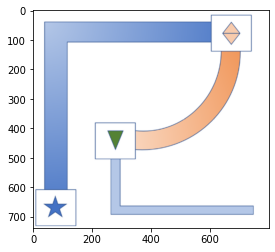

In [4]:
frame = cv2.imread("Picture1.png")
# frame = cv2.imread("Picture3.jpg")
frame = imutils.resize(frame, height=image_resolution, width = image_resolution)
original = frame.copy()
imshow(frame)

## Unsharp Masking

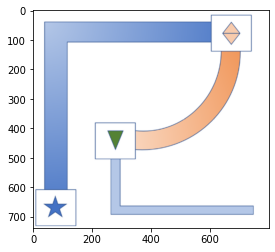

In [5]:
if UnsharpMaskBeforeFindMarker:
    blur = cv2.GaussianBlur(frame, BlurKernelSize, 0)
    frame = cv2.addWeighted(frame, 2, frame, -1, 0, frame) # Apply Unsharp Masking
    imshow(frame)
    cv2.imwrite("unsharp.jpg", frame)

## Enhance Marker Border

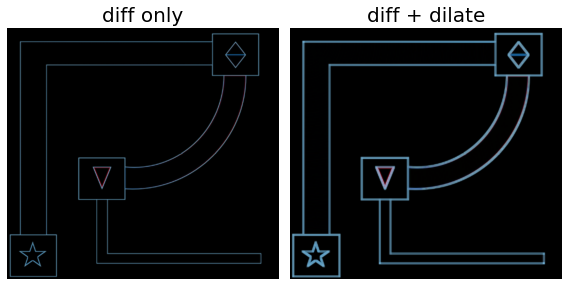

In [6]:
kernel = np.ones((5,5),np.uint8)
# Find Marker borer by difference
dilation = cv2.dilate(frame,kernel,iterations = 1)
diff = cv2.absdiff(dilation, frame)
# Enhance Marker border thickness
diff_dilated = cv2.dilate(diff,kernel,iterations = 1)

imshows([diff, diff_dilated], ['diff only', 'diff + dilate'])

# Select image with filtered border
frame = diff_dilated

## Find Marker

Match 95.03%
Match 97.07%
Match 96.65%


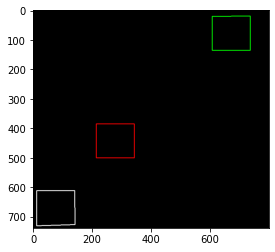

In [7]:
edges = cv2.Canny(frame, 20, 100)
contours,hierarchy = cv2.findContours(edges, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE) # RETR_EXTERNAL
hierarchy = hierarchy[0] # get the actual inner list of hierarchy descriptions

cp = unicorn.ContourProcessor()
cp.set_param(image_resolution, image_size, marker_size, marker_size_error)

cnts_marker = cp.get_marker_contours(contours)
imdraws_color(cnts_marker, frame, mode = 1, size = 2)

## Remove Marker from image

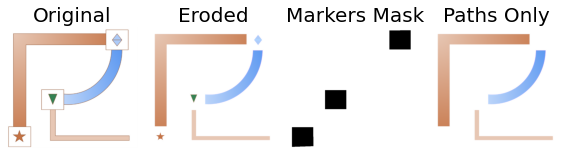

In [8]:
marker_mask = immasks(cnts_marker, frame, show = False)

## Erode image before masking to get rid of marker border
original_eroded = cv2.dilate(original.copy(),kernel,iterations = 2)

## Remove marker and fill with white
path_img = cv2.bitwise_and(original_eroded, original_eroded, mask=marker_mask)
path_img = cv2.fillPoly(path_img, cnts_marker, (255, 255, 255))
imshows([original, original_eroded, marker_mask, path_img], ['Original', 'Eroded', 'Markers Mask', 'Paths Only'])

## Find Contour of Paths

Found 3 path.


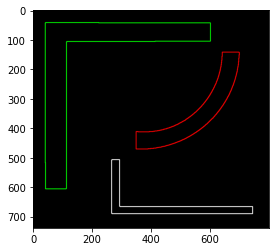

In [9]:
edges = cv2.Canny(path_img, 20, 100, apertureSize = 7, L2gradient = True)
# apertureSize: aperture size for the Sobel operator [Select from (3, 5, 7)]
# L2gradient: True = Euclidean Distance (More acculate), False = Manhattan Distance
cnts_path, hierarchy_path = cv2.findContours(edges,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print("Found {} path.".format(len(cnts_path)))
imdraws_color(cnts_path, frame, mode=1, size = 2)

## Process Paths data